# Предварительная загрузка данных

Подгружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from functools import partial


import warnings
warnings.filterwarnings(action='ignore')

sns.set()
%matplotlib inline

Загружаем датасеты

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gs = pd.read_csv('gender_submission.csv')

Смотрим на данные

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Данные для расчета точности

In [5]:
gs.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Напишем функцию, которая будет возвращать количество пропусков в столбце

In [8]:
def print_find_nan(dataset):
    for i in dataset.columns:
        if dataset[i].isnull().sum() > 0:
            print(f'Количество пропусков в {i} => {dataset[i].isnull().sum()}')

In [9]:
print_find_nan(train)

Количество пропусков в Age => 177
Количество пропусков в Cabin => 687
Количество пропусков в Embarked => 2


In [10]:
print_find_nan(test)

Количество пропусков в Age => 86
Количество пропусков в Fare => 1
Количество пропусков в Cabin => 327


# Обработка пропусков

Посмотрим на признаки Age в обучающем наборе данных

In [11]:
train['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Рассчитаем средний возраст мужчин и женщин для разных классов пассажиров. Заполним полученными значениями пропуски:

In [13]:
sex = {'male': 1, 'female': 0}

In [14]:
def convert_age(data):
    age = data.pivot_table(index='Pclass', values='Age', columns='Sex', aggfunc='mean').round().astype(int)
    for index in age.index:
        for column in age.columns:
            data.loc[((data['Age'].isnull()) & (data['Pclass'] == index) & (data['Sex'] == column)), 'Age'] = age.loc[:, column][index]

Заменим пропуски в возрасте:

Удалим признаки Cabin и Name, они имеют много пропусков и не информативен для модели. В тестовой и обучающей выборках есть еще признаки, имеющие пропуски. Их 3, удалим их и заменим данные пола на числовые.

In [15]:
# сохраним столбщец с Id пассажира для сохранения результата в самом конце
res_pass = test['PassengerId']

dropcol = ['PassengerId', 'Cabin', 'Name', 'Ticket']
for i in train, test:
    convert_age(i)
    i.drop(dropcol, axis=1, inplace=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


Рассмотрим признак Fare в тестовой выборке:

In [18]:
test[test['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,3,male,60.5,0,0,NaN,S


Заполним это нулевое значение медианой по классу размещения:

In [19]:
test.loc[test['Fare'].isnull(), 'Fare'] = test[(test['Sex'] == 'male') & (test['Pclass'] == 3)]['Fare'].median()

# Приведение типов

Приведем возраст к типу int, пол заменим на 0 для женщин и на 1 для мужчин:

In [20]:
for i in train, test:
    i['Age'] = i['Age'].astype(int)
    i['Sex'] = i['Sex'].map(sex)

Закодируем признаки Embarked с помощью числовых данных:

In [21]:
df_train = pd.get_dummies(train, drop_first=True).reset_index(drop=True)
df_test = pd.get_dummies(test, drop_first=True).reset_index(drop=True)

# Визуализация признаков

In [22]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22,1,0,7.2500,0,1
1,1,1,0,38,1,0,71.2833,0,0
2,1,3,0,26,0,0,7.9250,0,1
3,1,1,0,35,1,0,53.1000,0,1
4,0,3,1,35,0,0,8.0500,0,1


In [23]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,1,34,0,0,7.8292,1,0
1,3,0,47,1,0,7.0000,0,1
2,2,1,62,0,0,9.6875,1,0
3,3,1,27,0,0,8.6625,0,1
4,3,0,22,1,1,12.2875,0,1


0    549
1    342
Name: Survived, dtype: int64


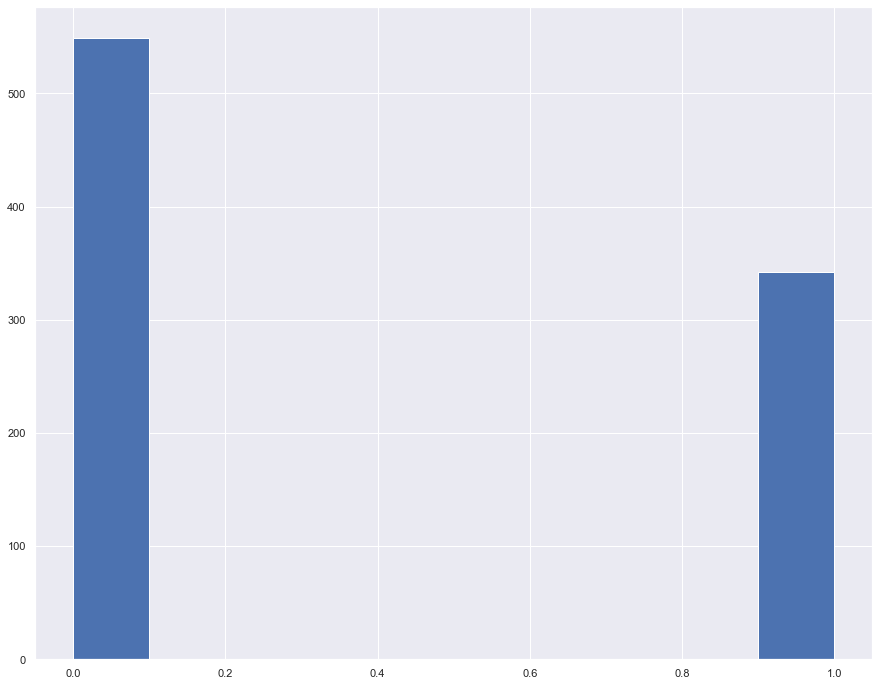

In [24]:
plt.figure(figsize=(15, 12))
plt.hist(df_train['Survived'])
print(df_train['Survived'].value_counts())

Посмотрим на корреляцию признаков

In [25]:
df_train.corr()['Survived'].sort_values(ascending=False)

Survived      1.000000
Fare          0.257307
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069004
Embarked_S   -0.155660
Pclass       -0.338481
Sex          -0.543351
Name: Survived, dtype: float64

Самые важные признаки Fare, Pclass и Sex. Построим боксплоты зависимостей этих параметров:

In [26]:
def print_box(data, x, y, hue):
    plt.figure(figsize=(15, 12))
    sns.boxplot(x=x, y=y, hue=hue, data=data, palette="Set3")

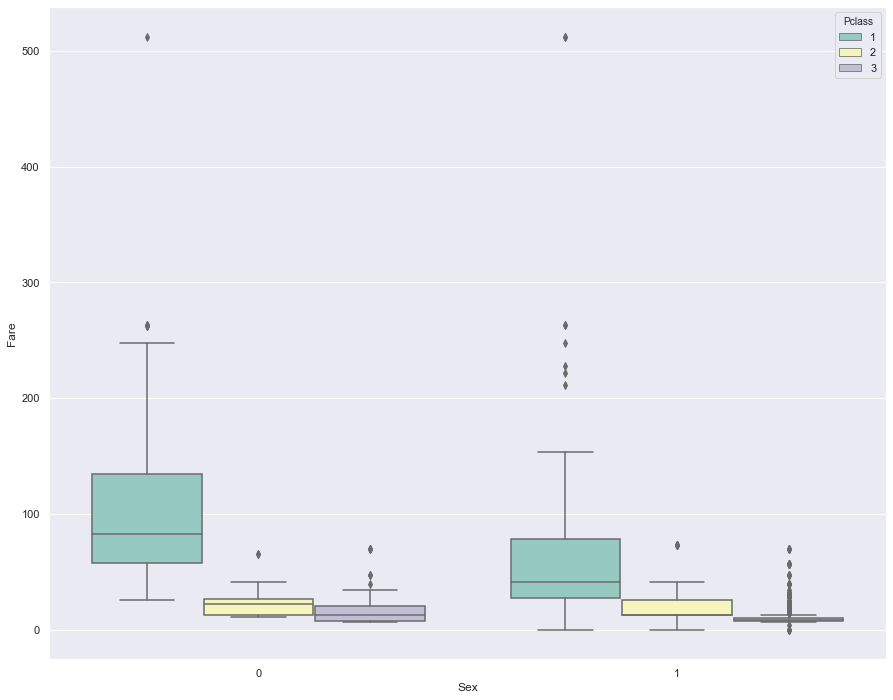

In [27]:
print_box(df_train, 'Sex', 'Fare', 'Pclass')

Удалим выбросы:

In [28]:
df_train = df_train[~((df_train['Fare'] > 200) & (df_train['Sex'] == 1))]
df_train = df_train[~((df_train['Fare'] > 250) & (df_train['Sex'] == 0))]

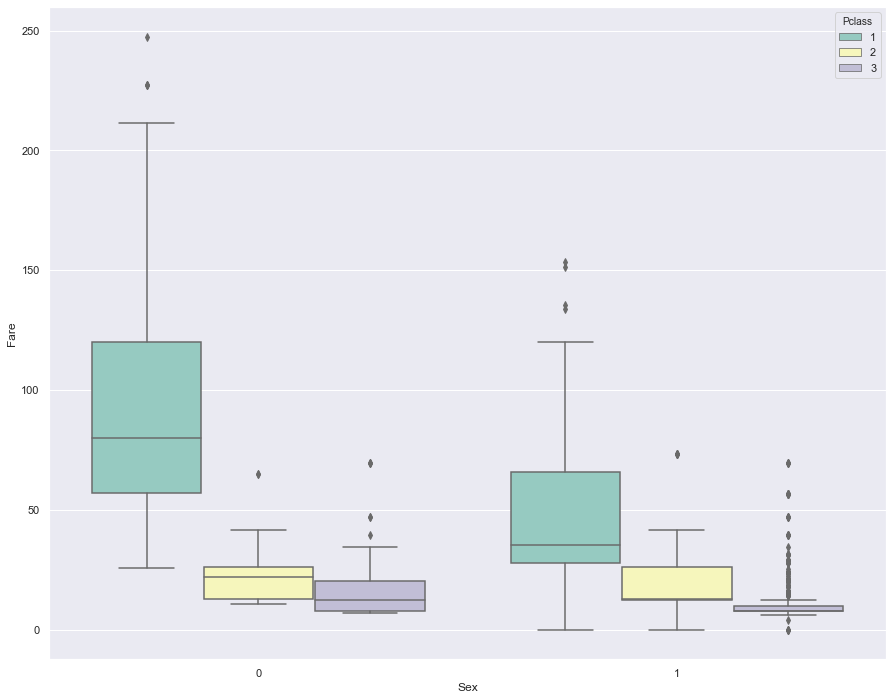

In [29]:
print_box(df_train, 'Sex', 'Fare', 'Pclass')

Посмотрим на распределение признаков в обучающей и тестовой выборках:

In [30]:
def print_hist(train, test, column):
    plt.figure(figsize=(15, 12))
    plt.hist(train[column], bins=20)
    plt.hist(test[column], bins=20)
    plt.title(column);

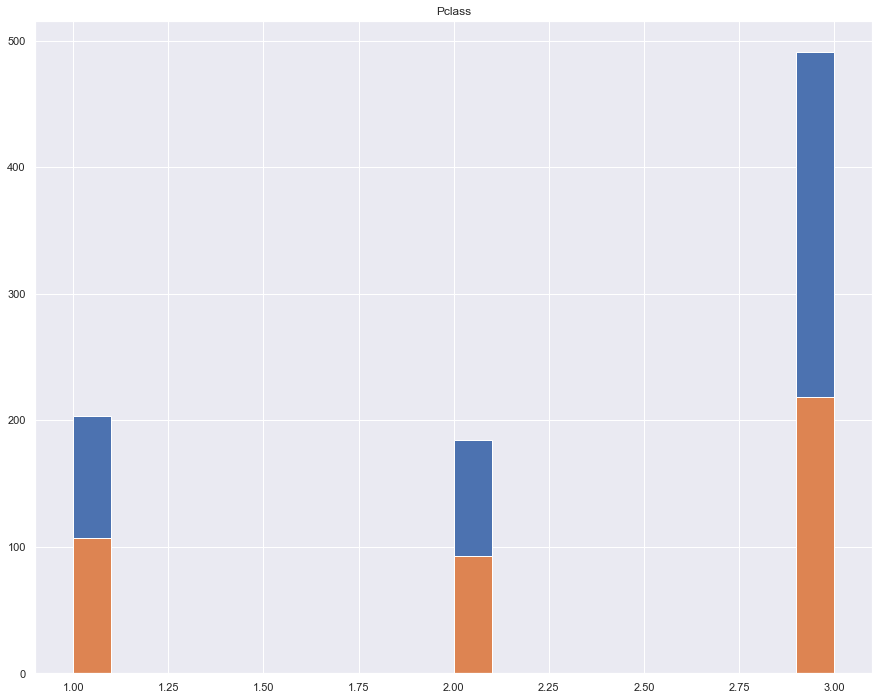

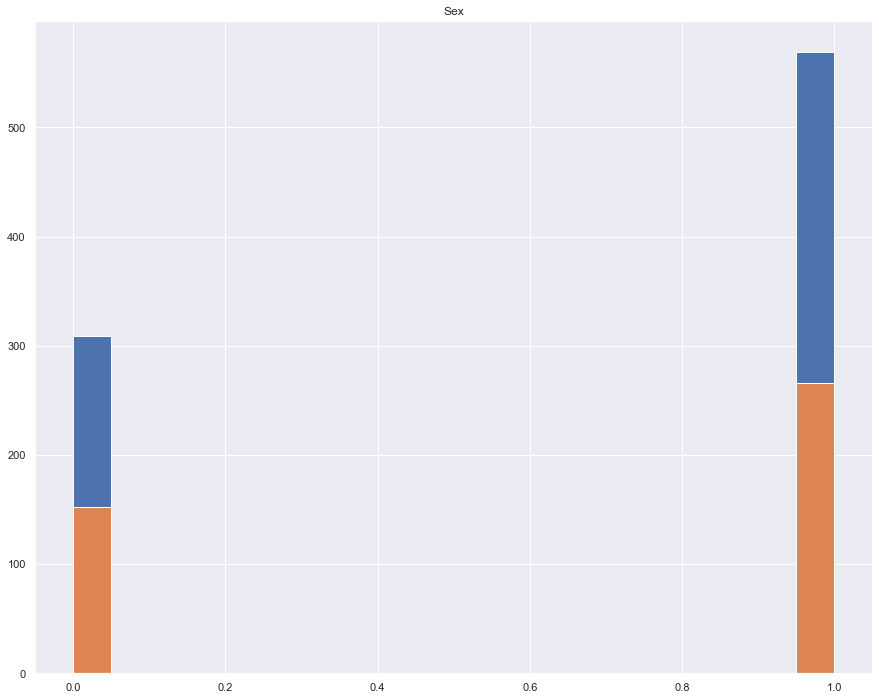

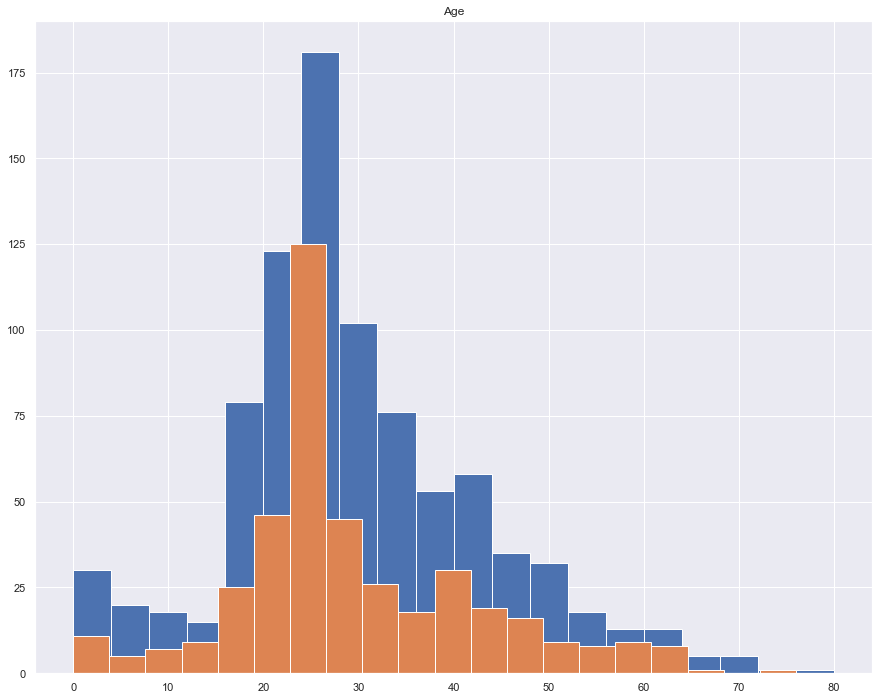

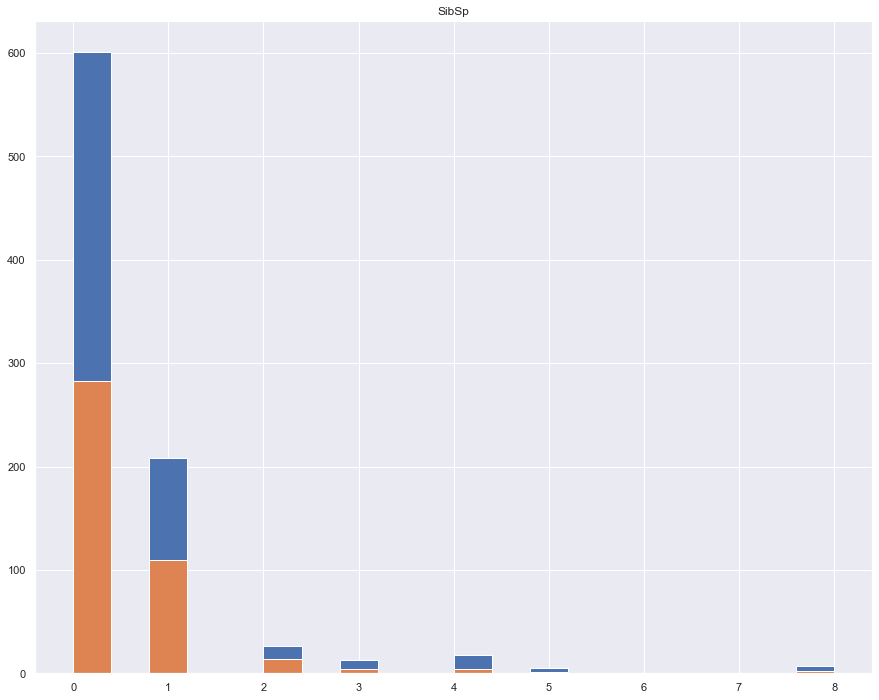

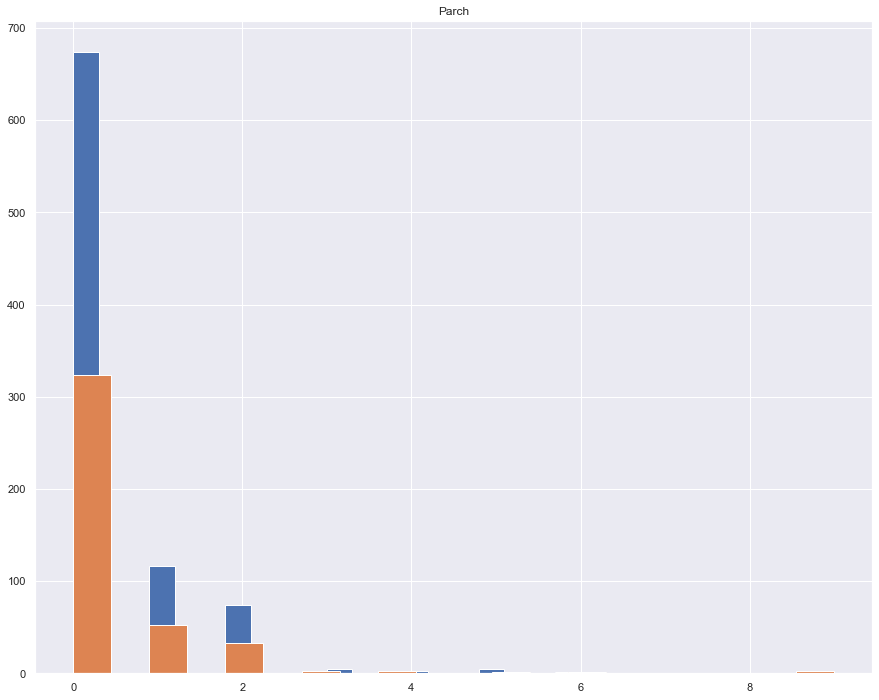

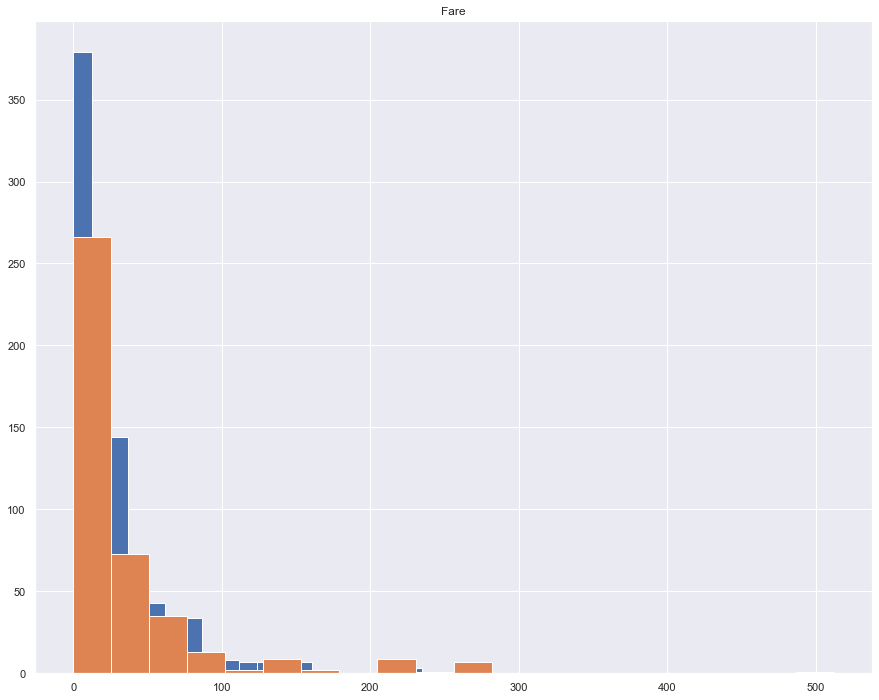

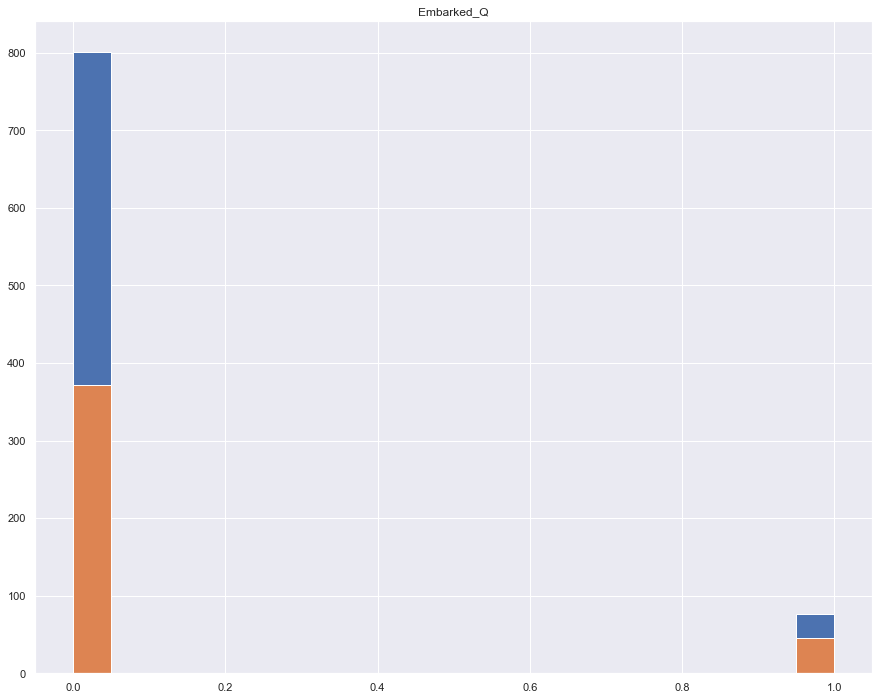

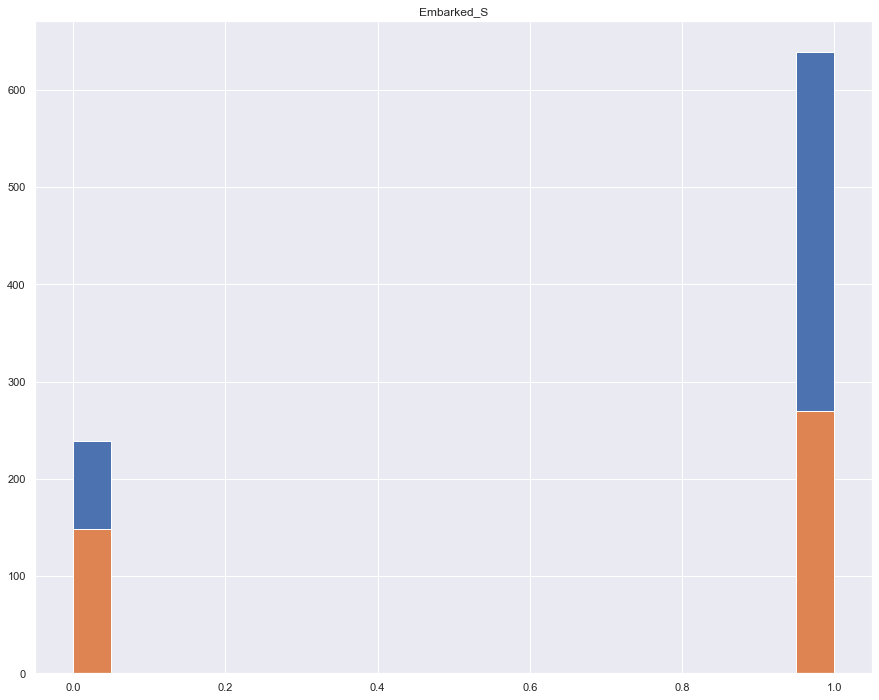

In [31]:
for i in df_test.columns:
    print_hist(df_train, df_test, i)

# Построение модели прогнозирования выживания

Обучим 3 модели и сравним качество их предсказаний на валидационной выборке. Подготовим модели, пока не будем их настраивать и посмотрим, что получится.

In [32]:
state = 42

model_log = LogisticRegression(random_state=state)
model_dt = DecisionTreeClassifier(random_state=state)
model_rf = RandomForestClassifier(random_state=state)

Запишем целевой признак и остальные признаки в отдельную переменную:

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('Survived', axis=1), df_train['Survived'], random_state=state, test_size=0.2)

In [34]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(702, 8) (176, 8) (702,) (176,)


Определим функцию, с помощью которой будем проводить кроссвалидацию и оценивать качество с помощью метрики accuracy

In [35]:
def fit_and_calc(model, name_model):
    #обучаем модель
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    print(f'Качество модели {name_model} => {accuracy_score(y_val, predict)}')
    print(f'Матрица неточностей:\n{confusion_matrix(y_val, predict)}')

In [36]:
for i in ((model_log, 'Логистическая регрессия'), (model_dt, 'Дерево решений'), (model_rf, 'Случайный лес')):
    fit_and_calc(i[0], i[1])

Качество модели Логистическая регрессия => 0.75
Матрица неточностей:
[[81 22]
 [22 51]]
Качество модели Дерево решений => 0.7386363636363636
Матрица неточностей:
[[79 24]
 [22 51]]
Качество модели Случайный лес => 0.7670454545454546
Матрица неточностей:
[[82 21]
 [20 53]]


Точность предсказания на тестовых данных > 75%. Посмотрим на процентное соотношение целевого признака.

In [37]:
df_train['Survived'].value_counts(normalize=True)

0    0.618451
1    0.381549
Name: Survived, dtype: float64

Полученные модели уже лучше случайного предсказания. Подберем гиперпараметры.

# Подбор гиперпараметров моделей

In [38]:
param_log = {
    'max_iter': range(100, 1001, 100), 'class_weight': ['balanced']}

param_tree = {
    'max_depth': range(3, 12), 
    'min_samples_leaf': range(2, 10),
    'class_weight': ['balanced']
    
}

param_forest = {
    'max_depth': range(3, 5),
    'n_estimators': range(38, 50, 1),
    'class_weight': ['balanced']
}

In [39]:
grid_log = GridSearchCV(model_log, param_log, cv=5, scoring='accuracy')
grid_dt = GridSearchCV(model_dt, param_tree, cv=5, scoring='accuracy')
grid_rf = GridSearchCV(model_rf, param_forest, cv=5, scoring='accuracy')

In [40]:
%%time
for i in grid_log, grid_dt, grid_rf:
    i.fit(X_train, y_train)

Wall time: 11.1 s


In [41]:
grid_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 5}

In [42]:
grid_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 40}

In [43]:
grid_rf.best_estimator_.classes_

array([0, 1], dtype=int64)

Посчитаем accuracy

In [44]:
for i in ((grid_log, 'Логистическая регрессия'), (grid_dt, 'Дерево решений'), (grid_rf, 'Случайный лес')):
    fit_and_calc(i[0], i[1])

Качество модели Логистическая регрессия => 0.7784090909090909
Матрица неточностей:
[[79 24]
 [15 58]]
Качество модели Дерево решений => 0.7784090909090909
Матрица неточностей:
[[81 22]
 [17 56]]
Качество модели Случайный лес => 0.7954545454545454
Матрица неточностей:
[[88 15]
 [21 52]]


Максимально возможное значение метрики равно 0,79 для случайного леса.

In [45]:
best_model_first = grid_rf.best_estimator_

# Повышение размерности признаков.

Мы имеем не равное соотношение целевых признаков:

In [46]:
df_train['Survived'].value_counts(normalize=True)

0    0.618451
1    0.381549
Name: Survived, dtype: float64

Целевых признаков с погибшими в 2 раза меньше. Увеличим количество этих признаков увеличением размерности:

In [47]:
# напишем функцию для повышения размерности
def upsample(features, target, repeat):
    
    # выделяем выборки с классами
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # повторяем необходимое количество раз признаки со значением целевого признака, равным 1
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # возвращаем перемешанные выборки
    return shuffle(features_upsampled, target_upsampled, random_state = 42)

In [48]:
X_train_up, y_train_up = upsample(df_train.drop('Survived', axis=1), df_train['Survived'], 2)

In [49]:
y_train_up.value_counts(normalize=True)

1    0.55235
0    0.44765
Name: Survived, dtype: float64

Теперь делаем все теже преобразования, что делали ранее:

In [50]:
# разбиваем выборку на валидационную и обучающую
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_train_up, y_train_up, random_state=state, test_size=0.3)

Подбираем гиперпараметры и обучаем модели:

In [51]:
def search_best_model(model, name_model, params, X_train, X_val, y_train, y_val):
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    print(f'Лучшие параметры модели {name_model} => {grid.best_params_}')
    predict = grid.best_estimator_.predict(X_val)
    print(f'Качество модели {name_model} => {accuracy_score(y_val, predict)}')
    print(f'Матрица неточностей:\n{confusion_matrix(y_val, predict)}')
    return accuracy_score(y_val, predict), grid.best_estimator_

In [52]:
# для исследования сократим немного запись атрибутов функции
search_best_up = partial(search_best_model, X_train = X_train_u, X_val = X_val_u, y_train = y_train_u, y_val = y_val_u)

In [53]:
best_up_model = 0
best_accuracy = 0

for i in ((model_log, 'Логистическая регрессия', param_log), (model_dt, 'Дерево решений', param_tree), (model_rf, 'Случайный лес', param_forest)):
    calc_accur, calc_model = search_best_up(i[0], i[1], i[2])
    if calc_accur >  best_accuracy:
        best_accuracy = calc_accur
        best_up_model = calc_model

Лучшие параметры модели Логистическая регрессия => {'class_weight': 'balanced', 'max_iter': 100}
Качество модели Логистическая регрессия => 0.7857142857142857
Матрица неточностей:
[[137  28]
 [ 50 149]]
Лучшие параметры модели Дерево решений => {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 3}
Качество модели Дерево решений => 0.8021978021978022
Матрица неточностей:
[[141  24]
 [ 48 151]]
Лучшие параметры модели Случайный лес => {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 38}
Качество модели Случайный лес => 0.7857142857142857
Матрица неточностей:
[[132  33]
 [ 45 154]]


In [54]:
best_accuracy

0.8021978021978022

Подберем параметры для случайного леса

In [55]:
param_forest_u = {
    'max_depth': range(11, 20),
    'n_estimators': range(86, 90, 1),
    'max_features': range(3, 8),
    'class_weight': ['balanced']
}

In [56]:
%%time
best_for_acc, best_for_model = search_best_up(model_rf, 'Случайный лес', param_forest_u)

Лучшие параметры модели Случайный лес => {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 4, 'n_estimators': 87}
Качество модели Случайный лес => 0.8818681318681318
Матрица неточностей:
[[134  31]
 [ 12 187]]
Wall time: 2min 23s


Точность 88 % - уже не плохо. Обучим эту модель на всех данных и сделаем предсказания.

In [57]:
model = best_for_model.fit(X_train_up, y_train_up)

In [58]:
result_predict = model.predict(df_test)

Сохраним в итоговый csv:

In [81]:
new_file = pd.DataFrame(res_pass, columns=['PassengerId'])
new_file['Survived'] = result_predict

In [85]:
new_file.to_csv('result.csv', index=False)